In [1]:
# Core libraries
import numpy as np
from skimage import io, util, morphology, exposure, filters, measure
from scipy.spatial import Voronoi, Delaunay
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# Specific utils
from imageUtils import draw_labels_on_image, colorize_segmentation, normalize_exposure_by_axis
from trimesh import Trimesh
from trimesh.curvature import discrete_gaussian_curvature_measure, \
    discrete_mean_curvature_measure, sphere_ball_intersection
import pyvista as pv

from sklearn import ensemble, linear_model, pipeline
from sklearn import preprocessing, model_selection, decomposition
from sklearn import metrics


# General utils
from os import path
import pickle as pkl
from tqdm import tqdm

def predict_feature(df:pd.DataFrame,
                    regressor,
                    feature2predict,
                    Niter:int=100,
                    bootstrap:bool=False,
                    model_settings={}):
    Y_test = []
    Y_pred = []
    models = []
    for i in tqdm(range(Niter)):

        pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      regressor(**model_settings) )
        
        y = df[feature2predict].astype(float)
        X = df.drop(columns=feature2predict).astype(float)
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y)
        
        model = pipe.fit(X_train,y_train)
        models.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),models]
    

# 0. Load datasets

In [2]:
from measurements import diagonalize_shparams

# Filenames
dirnames = {'R1':'/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/Shared/K10 paw/K10-R1',
            'R2':'/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/Shared/K10 paw/K10-R2'}

figure_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/Shared/K10 paw/Figures/RF_predict_k10_intensity'

df = {}
for name,dirname in dirnames.items():
    _df = pd.read_pickle(path.join(dirname,'Cropped/data_frame_aggregated.pkl'))
    _df['Region'] = name
    _df.index = name + '_' + _df.index.astype(str)
    df[name] = _df

regions = diagonalize_shparams(df)
for name,region in regions.items():
    region['Region'] = name
    regions[name] = region

df = pd.concat(regions.values())

non_borders = df[~df.Border]

cols2drop = ['Border','Region']
cols2drop += [f for f in non_borders.columns if 'Y' in f or 'X' in f or 'Z' in f]
cols2drop += [f for f in non_borders.columns if 'K10' in f]
cols2drop += [f for f in non_borders.columns if 'Total' in f or 'cell coords' in f]
cols2drop = pd.Index(cols2drop)

dx = 0.3
dz = 0.5
Z_SHIFT = 10
KAPPA = 5 # microns

# for expansion
footprint = morphology.cube(3)


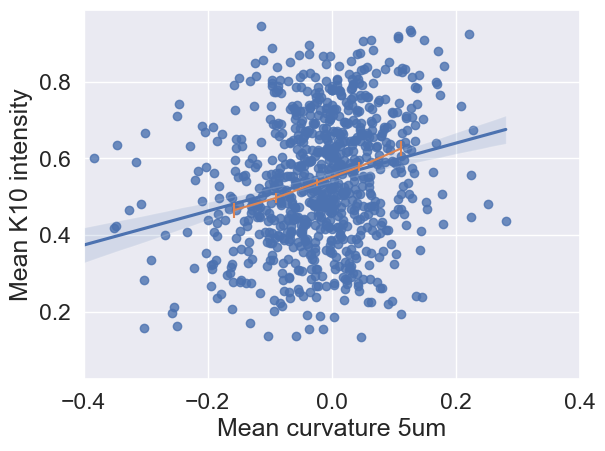

In [18]:
sb.regplot(df,x='Mean curvature 5um',y='Mean K10 intensity')

from basicUtils import plot_bin_means
plot_bin_means(df['Mean curvature 5um'],df['Mean K10 intensity'],bin_edges=13,minimum_n=20)
plt.xlim([-0.4,0.4])
plt.gcf().savefig(path.join(figure_dir,'mean_curv_v_k10.svg'))

In [6]:
# RandomForestRegression

Niter = 100
feature2predict = 'Mean K10 intensity'

df = non_borders.drop(columns=cols2drop.drop(feature2predict))
df = df.dropna(axis=0)

predictions,models = predict_feature(df,
                                     ensemble.RandomForestRegressor,
                                     # linear_model.ElasticNet,
                                     feature2predict,
                                     bootstrap=True,
                                     # model_settings={'alpha':0.01,'max_iter':1000,'l1_ratio':0.5},
                                     Niter=Niter)


100%|█████████████████████████████████████████████████████████████| 100/100 [05:26<00:00,  3.27s/it]


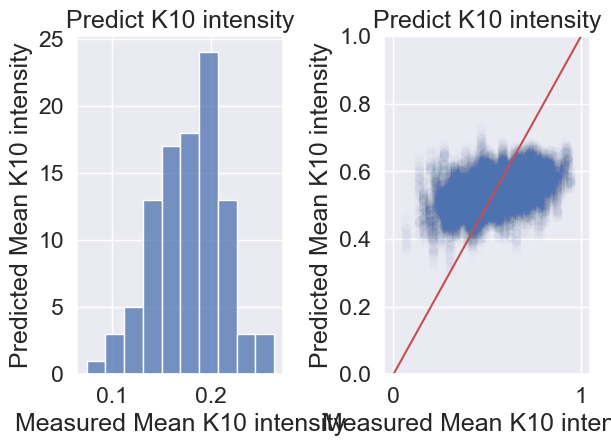

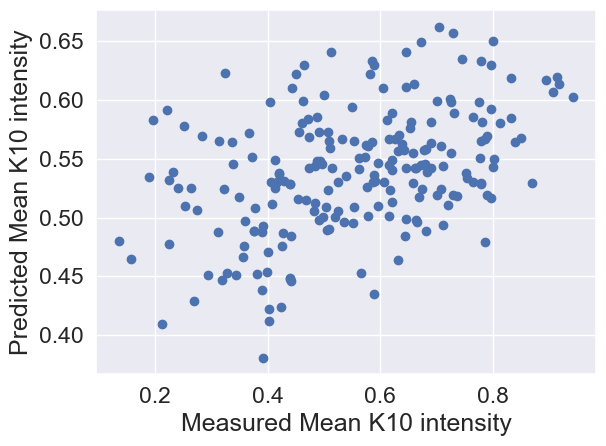

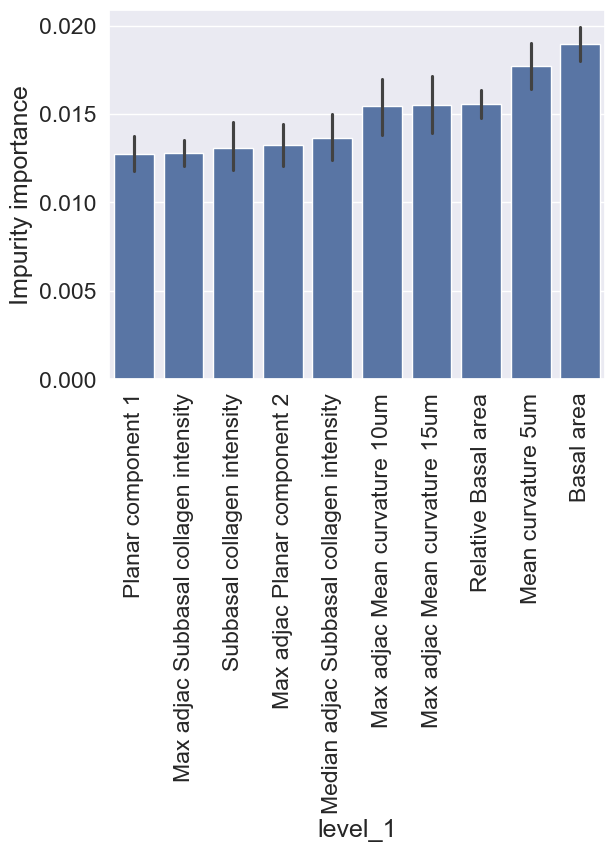

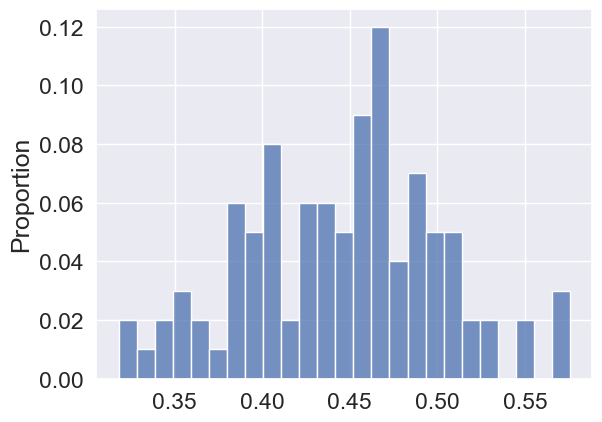

In [20]:
# Calculate the R2 score
r2_score = np.array([metrics.r2_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])

plt.subplot(1,2,1)
sb.set(font_scale=1.5)  # crazy big
plt.title('Predict K10 intensity')
sb.histplot(r2_score)
plt.xlabel(f'Measured {feature2predict}')
plt.ylabel(f'Predicted {feature2predict}')

plt.subplot(1,2,2)
plt.title('Predict K10 intensity')
plt.scatter(predictions[0,:].flatten(),predictions[1,:].flatten(),alpha=0.01)
plt.plot([0,1],[0,1],'r')
plt.xlabel(f'Measured {feature2predict}')
plt.ylabel(f'Predicted {feature2predict}')
plt.ylim([0,1])
plt.tight_layout()

plt.savefig(path.join(figure_dir,'RFreg_accuracy.svg'))

plt.figure()
plt.scatter(predictions[0,0].flatten(),predictions[1,0].flatten())
# plt.ylim([0,1])
# plt.plot([0,1],[0,1],'r')
plt.xlabel(f'Measured {feature2predict}')
plt.ylabel(f'Predicted {feature2predict}')

plt.tight_layout()

plt.savefig(path.join(figure_dir,'single_iteration_prediction.svg'))
r2_score.mean()

feat_names = df.columns.drop(feature2predict)
importances = pd.DataFrame(columns = feat_names,index=range(len(models)))
for i,m in enumerate(models):
    importances.loc[i,:] = m[1].feature_importances_

fig = plt.figure()
# importances.dropna(how='all').mean(axis=0).sort_values().dropna().tail(10).plot.bar()
sb.barplot(importances[importances.mean(axis=0).sort_values().dropna().tail(10).index].stack().reset_index(),x='level_1',y=0)
plt.ylabel('Impurity importance')
plt.xticks(rotation=90)
fig.savefig(path.join(figure_dir,'RF_impurity_importances.svg'))

fig = plt.figure()
sb.histplot([np.corrcoef(predictions[0,i,:], predictions[1,i,:])[0,1] for i in range(Niter)],bins=25,
           stat='proportion')

fig.savefig(path.join(figure_dir,'RF_pearson_R.svg'))

In [180]:
# RandomForestRegression

Niter = 100
feature2predict = 'Mean K10 intensity'

df = non_borders.drop(columns=cols2drop.drop(feature2predict))
df = df.dropna(axis=0)

predictions,models = predict_feature(df,
                                     linear_model.ElasticNet,
                                     feature2predict,
                                     bootstrap=True,
                                     model_settings={'alpha':0.01,'max_iter':1000,'l1_ratio':0.5},
                                     Niter=Niter)


100%|█████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.61it/s]


(array([ 9.,  8.,  3.,  2.,  0.,  2.,  0.,  1.,  3.,  3.,  2.,  6.,  7.,
         4.,  7.,  4.,  1.,  7.,  5., 11.,  2.,  4.,  2.,  6.,  1.]),
 array([0.09682986, 0.11229372, 0.12775758, 0.14322143, 0.15868529,
        0.17414914, 0.189613  , 0.20507685, 0.22054071, 0.23600456,
        0.25146842, 0.26693227, 0.28239613, 0.29785998, 0.31332384,
        0.32878769, 0.34425155, 0.3597154 , 0.37517926, 0.39064311,
        0.40610697, 0.42157082, 0.43703468, 0.45249853, 0.46796239,
        0.48342624]),
 <BarContainer object of 25 artists>)

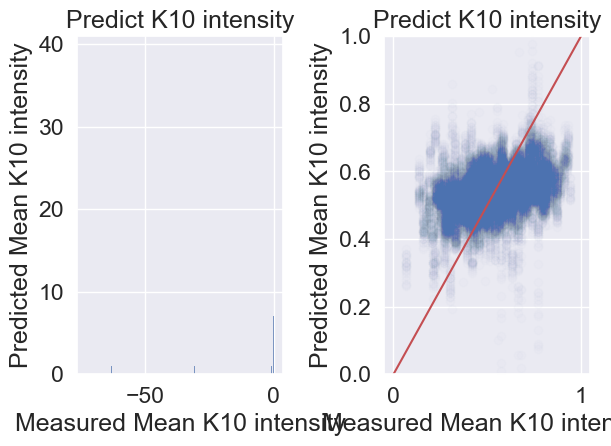

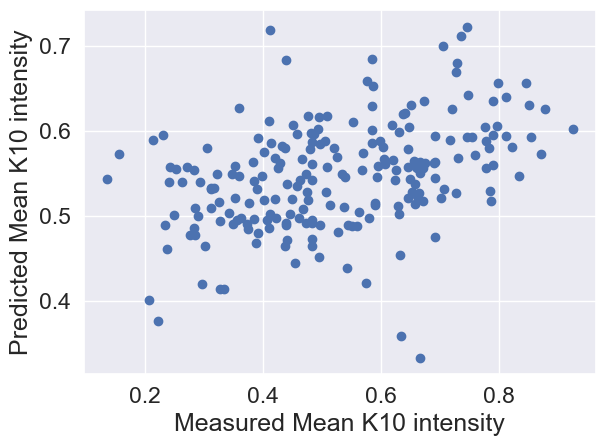

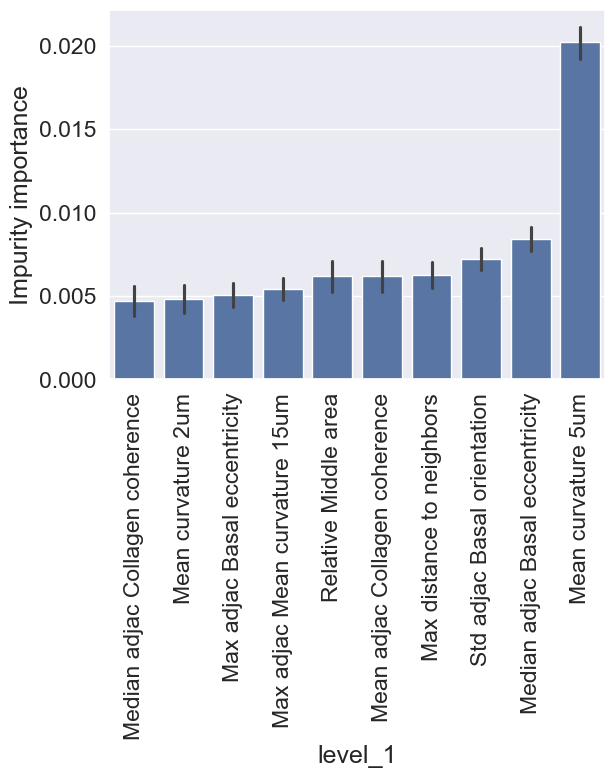

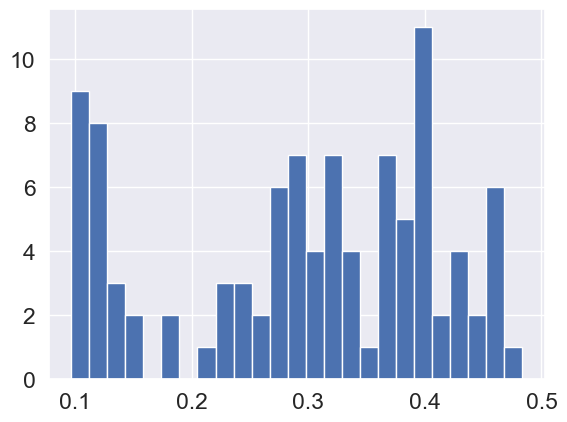

In [200]:
# Calculate the R2 score
r2_score = np.array([metrics.r2_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])

plt.subplot(1,2,1)
sb.set(font_scale=1.5)  # crazy big
plt.title('Predict K10 intensity')
sb.histplot(r2_score)
plt.xlabel(f'Measured {feature2predict}')
plt.ylabel(f'Predicted {feature2predict}')

plt.subplot(1,2,2)
plt.title('Predict K10 intensity')
plt.scatter(predictions[0,:].flatten(),predictions[1,:].flatten(),alpha=0.01)
plt.plot([0,1],[0,1],'r')
plt.xlabel(f'Measured {feature2predict}')
plt.ylabel(f'Predicted {feature2predict}')
plt.ylim([0,1])
plt.tight_layout()

plt.savefig(path.join(figure_dir,'GLMreg_accuracy.svg'))

plt.figure()
plt.scatter(predictions[0,0].flatten(),predictions[1,0].flatten())
# plt.ylim([0,1])
# plt.plot([0,1],[0,1],'r')
plt.xlabel(f'Measured {feature2predict}')
plt.ylabel(f'Predicted {feature2predict}')

plt.tight_layout()

plt.savefig(path.join(figure_dir,'GLM_single_iteration_prediction.svg'))
r2_score.mean()

feat_names = df.columns.drop(feature2predict)
importances = pd.DataFrame(columns = feat_names,index=range(len(models)))
for i,m in enumerate(models):
    importances.loc[i,:] = m[1].coef_

fig = plt.figure()
# importances.dropna(how='all').mean(axis=0).sort_values().dropna().tail(10).plot.bar()
sb.barplot(importances[importances.mean(axis=0).sort_values().dropna().tail(10).index].stack().reset_index(),x='level_1',y=0)
plt.ylabel('Impurity importance')
plt.xticks(rotation=90)
fig.savefig(path.join(figure_dir,'GLM_impurity_importances.svg'))
r2_score.mean()

plt.figure()
plt.hist([np.corrcoef(predictions[0,i,:], predictions[1,i,:])[0,1] for i in range(Niter)],25)

(array([ 9.,  8.,  3.,  2.,  0.,  2.,  0.,  1.,  3.,  3.,  2.,  6.,  7.,
         4.,  7.,  4.,  1.,  7.,  5., 11.,  2.,  4.,  2.,  6.,  1.]),
 array([0.09682986, 0.11229372, 0.12775758, 0.14322143, 0.15868529,
        0.17414914, 0.189613  , 0.20507685, 0.22054071, 0.23600456,
        0.25146842, 0.26693227, 0.28239613, 0.29785998, 0.31332384,
        0.32878769, 0.34425155, 0.3597154 , 0.37517926, 0.39064311,
        0.40610697, 0.42157082, 0.43703468, 0.45249853, 0.46796239,
        0.48342624]),
 <BarContainer object of 25 artists>)

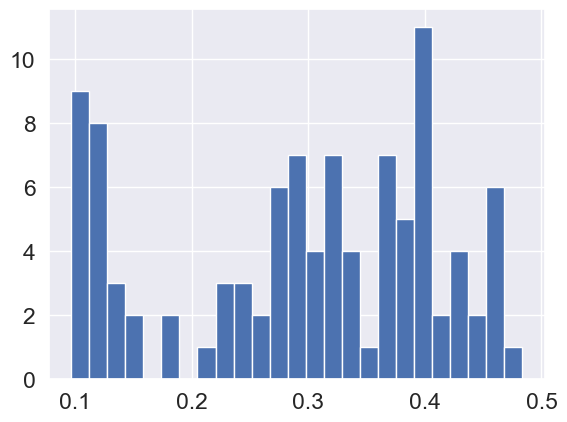

In [189]:
#%% XGboost

Niter = 100
feature2predict = 'Mean K10 intensity'

df = non_borders.drop(columns=cols2drop.drop(feature2predict))
predictions,models = predict_feature(df,
                                     ensemble.HistGradientBoostingRegressor,
                                     feature2predict,
                                     Niter=Niter)


  1%|▋                                                              | 1/100 [00:01<03:00,  1.83s/it]


KeyboardInterrupt: 

In [24]:
avg_confusion.mean()

np.float64(0.2159457179946811)

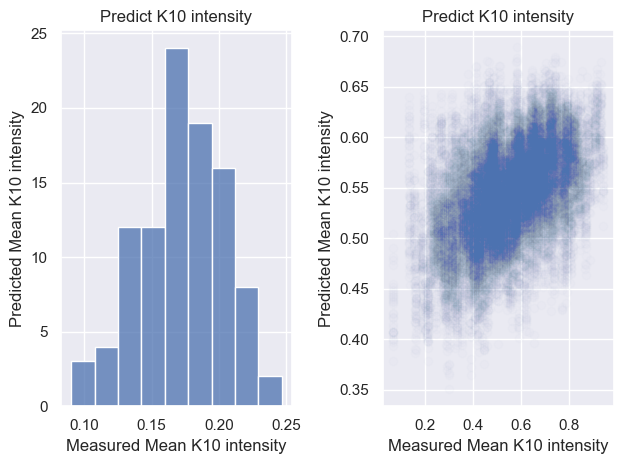

In [14]:
# Calculate the R2 score
r2_score = np.array([metrics.r2_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])

plt.subplot(1,2,1)
sb.set(font_scale=1)  # crazy big
plt.title('Predict K10 intensity')
sb.histplot(r2_score)
plt.xlabel(f'Measured {feature2predict}')
plt.ylabel(f'Predicted {feature2predict}')

plt.subplot(1,2,2)
plt.title('Predict K10 intensity')
plt.scatter(predictions[0,:].flatten(),predictions[1,:].flatten(),alpha=0.01)
# plt.plot([0,1],[0,1],'r')
plt.xlabel(f'Measured {feature2predict}')
plt.ylabel(f'Predicted {feature2predict}')

plt.tight_layout()

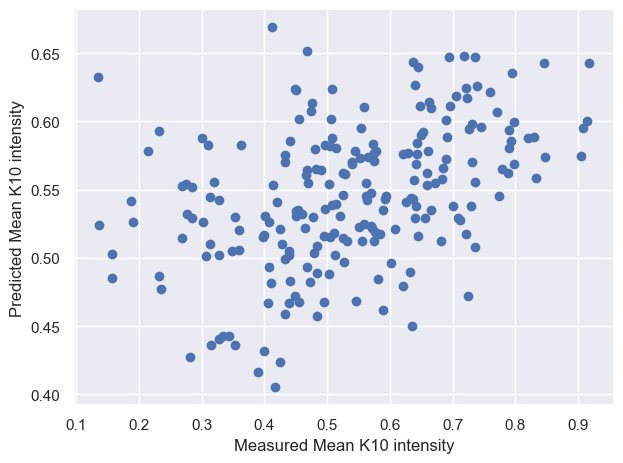

In [28]:
feat_names = df.columns.drop(feature2predict)
importances = pd.DataFrame(columns = feat_names,index=range(len(models)))
for i,m in enumerate(models):
    importances.loc[i,:] = m[1].feature_importances_

importances.dropna(how='all').mean(axis=0).sort_values().dropna().tail(6).plot.bar()

plt.ylabel('Impurity importance')


AttributeError: 'HistGradientBoostingRegressor' object has no attribute 'feature_importances_'

In [29]:
m[1].f

,loss,'squared_error'
,quantile,None
,learning_rate,0.1
,max_iter,100
,max_leaf_nodes,31
,max_depth,None
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'
